In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
from random import sample 
import time

BATCH_SIZE = 128
num_classes = 10


In [0]:
# # Read data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [0]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
input_layer = keras.Input(shape=(28, 28, 1)) # Convolution layer accepts input as (Batch_size, (x,y), channels). 
                                            # We don't need to specify batch size. Channels are, forexample, colors, RGB. This is black and white, so its 1
ConvLayer1 = Conv2D(32, kernel_size=(3,3),activation='relu')(input_layer)
ConvLayer2 = Conv2D(64, (3,3), activation='relu')(ConvLayer1)
D1 = Dropout(0.25)(ConvLayer2)
Flatten_layer = Flatten()(D1)
Dense1 = Dense(128, activation='relu')(Flatten_layer)
D2 = Dropout(0.5)(Dense1)
Dense2 = Dense(10, activation='softmax')(D2)

In [0]:
complete_model = keras.Model(inputs=input_layer, outputs = Dense2)
complete_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4718720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

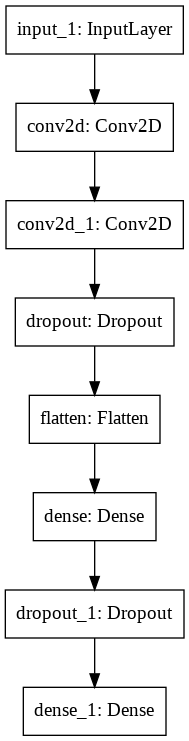

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(complete_model, to_file='model.png')

In [0]:
import random

def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

x_batch, y_batch = pack_batch(x_train, y_train, 60000, BATCH_SIZE)
print("x_batch size: %s" %str(len(x_batch)))
print(x_batch.shape)

x_batch size: 128
(128, 28, 28, 1)


In [0]:
optimizer = tf.keras.optimizers.Adadelta()

In [0]:
def loss(model, inputs, targets):
    y_ = model(inputs)
    return keras.losses.categorical_crossentropy(targets, y_, from_logits=False, label_smoothing=0)
    
def grad(model, inputs, targets): #Define gradients
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [0]:
loss(complete_model, x_batch, y_batch)

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([2.3774073, 2.2858212, 2.320053 , 2.457745 , 2.209021 , 2.4289744,
       2.2946177, 2.3173218, 2.4090447, 2.1996777, 2.2403014, 2.3178408,
       2.397018 , 2.250566 , 2.2167888, 2.3247464, 2.3591723, 2.2027755,
       2.4345481, 2.2972622, 2.4211898, 2.2919152, 2.3553343, 2.3258014,
       2.2390015, 2.374743 , 2.2965577, 2.2867734, 2.4521375, 2.2988725,
       2.3110077, 2.4095178, 2.2169807, 2.4471345, 2.2410417, 2.3416576,
       2.272114 , 2.359    , 2.2225657, 2.2779334, 2.3678062, 2.4089215,
       2.3181143, 2.345665 , 2.3711245, 2.414316 , 2.2956865, 2.3092477,
       2.202547 , 2.359024 , 2.3455567, 2.3613954, 2.2145708, 2.3855536,
       2.428363 , 2.2985864, 2.2296498, 2.2296398, 2.280584 , 2.299247 ,
       2.2561028, 2.2717562, 2.2691875, 2.2638001, 2.3014426, 2.2787864,
       2.25982  , 2.2425277, 2.2827108, 2.471119 , 2.2392054, 2.2562199,
       2.2120574, 2.4299834, 2.364163 , 2.3278153, 2.4151053, 2.2491832,
   

In [0]:
def validate_accuracy(model, features, targets):
    epoch_validation_accuracy = tf.keras.metrics.CategoricalAccuracy()
    epoch_validation_accuracy.update_state(targets, model(features))
    return epoch_validation_accuracy.result()

In [0]:
train_loss_results = []
train_accuracy_results = []
validation_accuracy = []

start_time = time.time()
epochs = 1500
for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    # Training loop - using batches of 32
    x,y = pack_batch(x_train, y_train, 60000, BATCH_SIZE)
    loss_value, grads = grad(complete_model, x, y)
    # print(loss_value)
    if (epoch%100==0):
        print("Running epoch %d, %d epochs left" %(epoch, epochs-epoch))
    optimizer.apply_gradients(zip(grads, complete_model.trainable_variables))
    x_validation, y_validation = pack_batch(x_test, y_test, 10000, 50)
    validation_accuracy.append(validate_accuracy(complete_model,x_validation,y_validation))
    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, complete_model(x, training=True))

  # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

print("Time taken: %d" %(time.time() - start_time))


Running epoch 0, 1500 epochs left
Running epoch 100, 1400 epochs left
Running epoch 200, 1300 epochs left
Running epoch 300, 1200 epochs left
Running epoch 400, 1100 epochs left
Running epoch 500, 1000 epochs left
Running epoch 600, 900 epochs left
Running epoch 700, 800 epochs left
Running epoch 800, 700 epochs left
Running epoch 900, 600 epochs left
Running epoch 1000, 500 epochs left
Running epoch 1100, 400 epochs left
Running epoch 1200, 300 epochs left
Running epoch 1300, 200 epochs left
Running epoch 1400, 100 epochs left
Time taken: 83


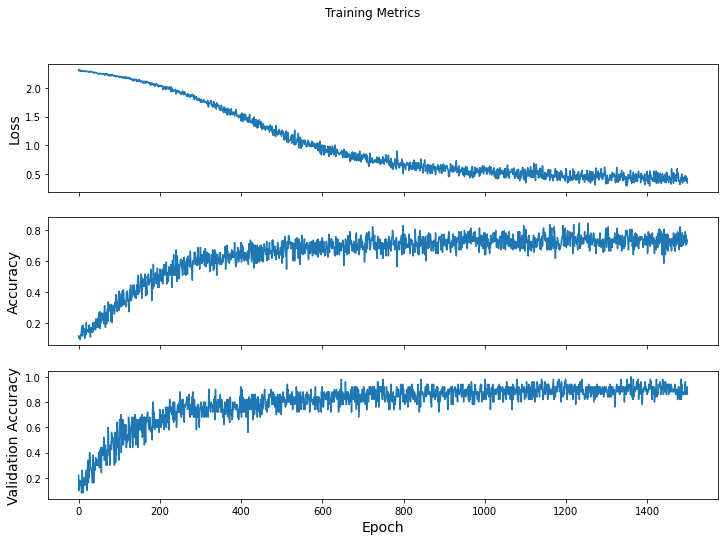

In [0]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(train_accuracy_results)

axes[2].set_ylabel("Validation Accuracy", fontsize=14)
axes[2].set_xlabel("Epoch", fontsize=14)
axes[2].plot(validation_accuracy)

plt.show()